# import

In [1]:
import os
import re
import pandas as pd
from utils import *

# 0. Load data

In [2]:
# author code
x_tr_df = pd.read_csv('train_folder/x_train_ids.csv', index_col=0)
tr_dir = "train_folder/txt_files/"
tr_files = x_tr_df['filename'].values

tr_texts = []
for tr_file in tr_files:
    f = open(os.path.join(tr_dir, tr_file), "r")
    ff = f.read()
    ff = clean1(ff)
    tr_texts.append(ff)
# tr_texts has all the texts in it

In [3]:
#y_train data
y_tr_df = pd.read_csv('train_folder/Y_train_predilex.csv', index_col=0)

In [18]:
y_tr_df.date_consolidation == 'n.a.'

ID
0      False
1      False
2      False
3      False
4      False
       ...  
765    False
766    False
767    False
768    False
769    False
Name: date_consolidation, Length: 770, dtype: bool

# 1. Find all possible patterns for dates

In [13]:
# all index of the year of the accident 
all_dates = []
for i in range(len(tr_texts)):
    if y_tr_df['date_accident'][i] != 'n.c.':
        ff = [m.start() for m in re.finditer(y_tr_df['date_accident'][i][:4], tr_texts[i])]
    else:
        ff = []
    all_dates.append(ff)

In [6]:
# check if there is the day digit near the year digit
sentences = []
for ind in range(len(tr_texts)):
    sentence = []
    window = 15
    for date in all_dates[ind]:
        left = tr_texts[ind][date - window : date]
        right = tr_texts[ind][date + 4 : date + 4 + window]
        left_num = re.findall(r'\d', left)
        right_num = re.findall(r'\d', right)
        if len(left_num) == 0 & len(right_num) == 0:
            pass
        else:
            text = tr_texts[ind][date - window : date + 4 + window]
            sentence.append(text)
    sentences.append(sentence)

In [5]:
# find all pattern of dates
pattern1 = r"\d{1,2} \w{3,9} \d{2,4}"
pattern2 = r"1° \w{3,9} \d{2,4}"
pattern3 = r"1er \w{3,9} \d{2,4}"
pattern4 = r"\d{1,2}\.\d{1,2}\.\d{2,4}"
pattern5 = r"\d{1,2}/\d{1,2}/\d{2,4}"
pattern6 = r"\d{1,2} / \d{1,2} / \d{2,4}"
pattern7 = r"\d{1,2}/ \d{1,2}/ \d{2,4}"
pattern8 = r"\d{1,2}\. \d{1,2}\. \d{2,4}"


pattern1_bis = r"(\d{1,2}) (\w{3,9}) (\d{2,4})"
pattern2_bis = r"(1°) (\w{3,9}) (\d{2,4})"
pattern3_bis = r"(1er) (\w{3,9}) (\d{2,4})"
pattern4_bis = r"(\d{1,2})\.(\d{1,2})\.(\d{2,4})"
pattern5_bis = r"(\d{1,2})/(\d{1,2})/(\d{2,4})"
pattern6_bis = r"(\d{1,2}) / (\d{1,2}) / (\d{2,4})"
pattern7_bis = r"(\d{1,2})/ (\d{1,2})/ (\d{2,4})"
pattern8_bis = r"(\d{1,2})\. (\d{1,2})\. (\d{2,4})"

patterns = [pattern1, pattern2, pattern3, pattern4, pattern5, pattern6, pattern7, pattern8] 
patterns_bis = [pattern1_bis, pattern2_bis, pattern3_bis, pattern4_bis, pattern5_bis, pattern6_bis, pattern7_bis, pattern8_bis] 

In [10]:
# check the number of sentences that doesnt get detected using preious patterns
dates = []
fails = []
for i in range(len(sentences)):
    date = []
    index = []
    for sentence in sentences[i]:
        l = []
        for pattern in patterns:
            l.extend(re.findall(pattern, sentence))
        if len(l) == 0:
            fails.append(sentence)
        date.extend(l)
    dates.append(date)

In [11]:
len(fails)

100

In [103]:
fails

['97 à septembre 1998), qu’ainsi son',
 'e 35 000 € (en 2000 revenus mensue',
 'ins du 1o août 2002 au 13 janvier ',
 '4. 773,00 € en 2002 : 30. 321,00 €',
 ' entre 2002 et 2003 s’élevant à 17',
 'enu le 1o mars 2002 n’est pas l’ob',
 '( 9029,93 € en 2002 + 22.934,66 € ',
 'n 1996 puis en 1997 mme myriam yyy',
 '996 et janvier 1997 n’aurait pas r',
 '996 et janvier 1997 de sorte qu’il',
 ' de 1996 et de 1997) ni la qualité',
 'tions de 1996, 1997, 1998, 1999, 2',
 ' de 1996 et de 1997 - date de cons',
 ' mois du 10-04-1996 au 13-05-1997 ',
 'r 2001 puis en 2001 et 2002, ainsi',
 'e : 2, 5 / 7 : 2000 € et compte te',
 'que, de 1996 à 2007 “. la société ',
 'ste, de 1996 à 2007, son travail c',
 '08 à septembre 2008. secondairemen',
 '2007 à février 2008 ainsi que la s',
 '2008 à février 2009 “ du fait de t',
 'tratif 10 sep. 2009 “. il n’est pa',
 ', le 15décembre1992, que l’acciden',
 'bert z... ... 72000 le mans la mut',
 'vril 2009 -non 2008, l’accident ét',
 ' 81 en février 2004 (il

# 2. Creating Training Set

In [51]:
import nltk
from tqdm import tqdm
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/fei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/fei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
stemmer = SnowballStemmer('french')
lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('french'))

In [53]:
months_str_to_int = dict(janvier='01', fevrier='02', mars='03', avril='04', mai='05', juin='06',
                         juillet='07', aout='08', septembre='09', octobre='10', novembre='11',
                         decembre='12')

def format_date(day:str, month:str, year:str):
    if len(day) == 1:
        day = '0' + day
    elif not day.isnumeric():
        day = '01'
    if not month.isnumeric():
        month = months_str_to_int[month]
    elif len(month) == 1:
        month = '0' + month
    if len(year) == 2:
        if int(year) < 30: year = '20' + year
        else: year = '19' + year
    return day, month, year

In [54]:
x_train = []
y_train = []
for i in tqdm(range(len(tr_texts))):
    if y_tr_df.iloc[i]['date_consolidation'] != 'n.c.' and y_tr_df.iloc[i]['date_consolidation'] != 'n.a.':
        text = tr_texts[i]
        index = []
        dates = []
        for k, pattern in enumerate(patterns):
            index.extend(re.finditer(pattern, text))
            dates.extend(re.findall(patterns_bis[k], text))
    
    
        zipped = sorted(list(zip(index,dates)), key = lambda x: x[0].start())
        for j in range((len(index))):
            index[j] = zipped[j][0]
            dates[j] = zipped[j][1]
        index = index[3:]
        dates = dates[3:]
    
        window = 100
        for k, ind in enumerate(index):
            
            day, month, year = dates[k][0], dates[k][1], dates[k][2]
            month = month.lower().replace('é', 'e').replace('û', 'u')
            if (month in months_str_to_int) or (month in months_str_to_int.values()):
                day, month, year = format_date(day, month, year)
                date = f"{year}-{month}-{day}"
                
                if ind.start() > window and ind.end() + window < len(text):
                    chunk = text[ind.start() - window: ind.end() + window]
                elif ind.start() <= window:
                    chunk = text[: ind.end() + 2*window]
                elif ind.end() +window >= len(text):
                    chunk = text[len(text) - 2*window:]
                chunk = re.sub(r"^[^\s]*\s*", "", chunk)
                chunk = re.sub(r"\s*[^\s]*$", "", chunk)
                chunk = clean2(chunk, lemmatizer, stemmer, stop_words = stop_words)

                x_train.append(chunk)

                if date == y_tr_df.iloc[i]['date_consolidation']: y_train.append(1)
                else: y_train.append(0)

100%|██████████| 770/770 [00:18<00:00, 40.76it/s]


In [55]:
y_train = np.array(y_train)

# 3. Training Model

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

In [57]:
TF_IDF = TfidfVectorizer(ngram_range=(1, 2), max_features=500, norm='l2', sublinear_tf=True)
x_train = TF_IDF.fit_transform(x_train).toarray()

In [165]:
random_state = 42

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [.1],
    'subsample': [.7, .9],
    'colsample_bytree': [.7, .9],
}
classifier, best_thresh, best_params = grid_search(x_train, y_train, param_grid)

KeyboardInterrupt: 

In [28]:
best_params

{'max_depth': 5,
 'learning_rate': 0.1,
 'subsample': 0.7,
 'colsample_bytree': 0.9,
 'random_state': 42}

In [58]:
classifier = XGBClassifier(max_depth = 5,
                           learning_rate = 0.1,
                           subsample = 0.7,
                           colsample_bytree = 0.9,
                           random_state = 42)

In [59]:
classifier.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=None,
              validate_parameters=False, verbosity=None)

In [60]:
proba = classifier.predict_proba(x_train)

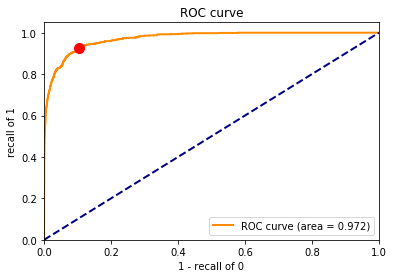

optimal threshold is 0.05190190300345421


In [61]:
t, _ = find_opti_thresh(y_train, proba[:,1])

# 4. Predict accident date in a text

In [62]:
candidates = []
candidates_txt = []
sentence_dates = []
true_dates = []
for i in tqdm(range(len(tr_texts))):
    if y_tr_df.iloc[i]['date_consolidation'] != 'n.c.' and y_tr_df.iloc[i]['date_consolidation'] != 'n.a.':
        text = tr_texts[i]
        index = []
        dates = []
        for k, pattern in enumerate(patterns):
            index.extend(re.finditer(pattern, text))
            dates.extend(re.findall(patterns_bis[k], text))
            
        zipped = sorted(list(zip(index,dates)), key = lambda x: x[0].start())
        for j in range((len(index))):
            index[j] = zipped[j][0]
            dates[j] = zipped[j][1]
        index = index[3:]
        dates = dates[3:]
        
        window = 100
        data = []
        data_txt = []
        s_d = []
        for k, ind in enumerate(index):
            day, month, year = dates[k][0], dates[k][1], dates[k][2]
            month = month.lower().replace('é', 'e').replace('û', 'u')
            if month in months_str_to_int or month in months_str_to_int.values():
                day, month, year = format_date(day, month, year)
                date = f"{year}-{month}-{day}"

                if ind.start() > window and ind.end() + window < len(text):
                    chunk = text[ind.start() - window: ind.end() + window]
                elif ind.start() <= window:
                    chunk = text[: ind.end() + 2*window]
                elif ind.end() +window >= len(text):
                    chunk = text[len(text) - 2*window:]
                chunk = re.sub(r"^[^\s]*\s*", "", chunk)
                chunk = re.sub(r"\s*[^\s]*$", "", chunk)

                data_txt.append(chunk)

                chunk = clean2(chunk, lemmatizer, stemmer, stop_words = stop_words)
                data.append(chunk)
                s_d.append(date)

        candidates.append(data)
        candidates_txt.append(data_txt)
        sentence_dates.append(s_d)
        true_dates.append(y_tr_df.iloc[i]['date_consolidation'])

100%|██████████| 770/770 [00:17<00:00, 44.78it/s]


In [63]:
for i in range(len(candidates)):
    candidate = TF_IDF.transform(candidates[i]).toarray()
    candidates[i] = candidate

In [64]:
preds = []
L = []
all_scores = []
for i, candidate in enumerate(candidates):
    out = classifier.predict_proba(candidate)[:,1]
    all_scores.append(list(out))
    pred = np.argmax(out)
    score = np.max(out)
    pred_date = sentence_dates[i][pred]
    preds.append(pred_date)
    if score < 0.2: L.append((score, i, pred))

In [65]:
for i, score in enumerate(all_scores):
    score = [(score[j], j) for j, _ in enumerate(score)]
    score = sorted(score, key = lambda x: x[0], reverse = True)
    all_scores[i] = score

In [66]:
accuracy = 0
for i in range(len(preds)):
    if preds[i] == true_dates[i]:
        accuracy += 1
accuracy/len(preds)

0.9042316258351893

## 4.1 checking errors

In [ ]:
# 14/11/99 not detected
# sentence not explicitly stating accident or not long enough

In [189]:
L

[(0.1227333, 7, 9),
 (0.18282376, 47, 36),
 (0.07101397, 66, 16),
 (0.102354184, 119, 26),
 (0.11321503, 207, 38),
 (0.14621095, 209, 11),
 (0.13175452, 222, 18),
 (0.19334021, 237, 19),
 (0.10772764, 241, 14),
 (0.12584545, 257, 16),
 (0.1652214, 278, 17),
 (0.085684225, 310, 13),
 (0.03627394, 326, 0),
 (0.16099206, 336, 13),
 (0.07627484, 337, 30),
 (0.093213424, 340, 21),
 (0.17403415, 345, 6),
 (0.18585391, 354, 7),
 (0.16843969, 367, 8),
 (0.11082484, 380, 8),
 (0.08870588, 381, 15),
 (0.074391276, 385, 21),
 (0.08943464, 400, 3),
 (0.07912295, 411, 13),
 (0.11098801, 418, 20),
 (0.17323886, 421, 18),
 (0.18429677, 437, 14),
 (0.1314131, 441, 2),
 (0.17207965, 505, 9),
 (0.090780936, 511, 9),
 (0.18726933, 513, 7),
 (0.14652322, 515, 18),
 (0.18034413, 521, 27),
 (0.17933044, 534, 32),
 (0.089126155, 567, 7),
 (0.17681623, 570, 22),
 (0.13684788, 577, 5),
 (0.16812935, 579, 20),
 (0.1936722, 583, 41),
 (0.119739644, 605, 17),
 (0.1829019, 611, 8),
 (0.15808034, 621, 18),
 (0.1692

In [192]:
indice = 7
true_dates[indice]

'1994-05-31'

In [193]:
all_scores[indice]

[(0.1227333, 9),
 (0.09459285, 12),
 (0.079517335, 4),
 (0.065727755, 10),
 (0.0634461, 8),
 (0.055303328, 6),
 (0.054202486, 16),
 (0.04921267, 11),
 (0.045357123, 15),
 (0.04439468, 14),
 (0.042043928, 17),
 (0.036830947, 13),
 (0.03627394, 0),
 (0.03627394, 1),
 (0.03627394, 20),
 (0.031841308, 7),
 (0.026226785, 19),
 (0.025140014, 18),
 (0.020819057, 3),
 (0.011471014, 5),
 (0.0038249707, 2)]

In [195]:
candidates_txt[indice][12]

'ule du constat posé par le docteur b., médecin du travail qui retraçant dans un courrier adressé le 4 septembre 1995 à l’employeur l’historique de la maladie, indique avoir revu didier a. postérieurement à sa nouvell'

#  3. Predict test data 

In [67]:
#x_test data
x_te_df = pd.read_csv('test_folder/x_test_ids.csv', index_col=0)
te_dir = "test_folder/txt_files/"
te_files = x_te_df['filename'].values
te_texts = []
for te_file in te_files:
    f = open(os.path.join(te_dir, te_file), "r")
    ff = f.read()
    ff = clean1(ff)
    te_texts.append(ff)

In [68]:
candidates = []
sentence_dates = []
for i in tqdm(range(len(te_texts))):
    text = te_texts[i]
    index = []
    dates = []
    for k, pattern in enumerate(patterns):
        index.extend(re.finditer(pattern, text))
        dates.extend(re.findall(patterns_bis[k], text))

    zipped = sorted(list(zip(index,dates)), key = lambda x: x[0].start())
    for j in range((len(index))):
        index[j] = zipped[j][0]
        dates[j] = zipped[j][1]
    index = index[3:]
    dates = dates[3:]
    
    window = 100
    data = []
    s_d = []
    for k, ind in enumerate(index):
        day, month, year = dates[k][0], dates[k][1], dates[k][2]
        month = month.lower().replace('é', 'e').replace('û', 'u')
        if month in months_str_to_int:
            day, month, year = format_date(day, month, year)
            date = f"{year}-{month}-{day}"

            if ind.start() > window and ind.end() + window < len(text):
                chunk = text[ind.start() - window: ind.end() + window]
            elif ind.start() <= window:
                chunk = text[: ind.end() + 2*window]
            elif ind.end() + window >= len(text):
                chunk = text[len(text) - 2*window:]
            chunk = re.sub(r"^[^\s]*\s*", "", chunk)
            chunk = re.sub(r"\s*[^\s]*$", "", chunk)

            chunk = clean2(chunk, lemmatizer, stemmer, stop_words = stop_words)
            data.append(chunk)
            s_d.append(date)

    candidates.append(data)
    sentence_dates.append(s_d)

100%|██████████| 257/257 [00:08<00:00, 30.35it/s]


In [69]:
for i in range(len(candidates)):
    candidate = TF_IDF.transform(candidates[i]).toarray()
    candidates[i] = candidate

In [70]:
preds = []
for i, candidate in enumerate(candidates):
    pred = np.argmax(classifier.predict_proba(candidate)[:,1])
    score = np.max(classifier.predict_proba(candidate)[:,1])
    if score < t: preds.append('n.c.')
    else:
        pred_date = sentence_dates[i][pred]
        preds.append(pred_date)

In [71]:
np.save('results/consolidation.npy', preds)